<a href="https://colab.research.google.com/github/Slimlav/Netology/blob/main/%D0%AD%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%80%D0%BD%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**
- Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
WCOTD= pd.read_csv('weekly-closings-of-the-dowjones-.csv')
series = {'Weekly closings of the Dow-Jones industrial average': WCOTD["Close"]}

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Stationary')

        plt.tight_layout()
    return

In [4]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [5]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [6]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [7]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

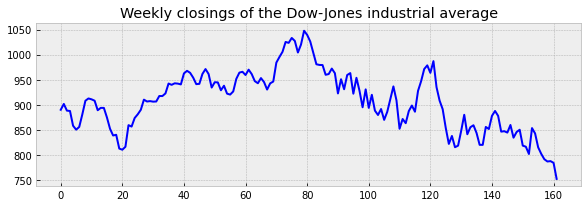

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [9]:
series = WCOTD['Close']
train, test, val = series[:60], series[60:70], series[70:]

In [10]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [11]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [12]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 52.34023705339074
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.65556458e-04,  2.21120899e-03, -4.19220214e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 124
      nit: 17
     njev: 31
   status: 0
  success: True
        x: array([0.36836965, 0.01087965, 0.38611391])


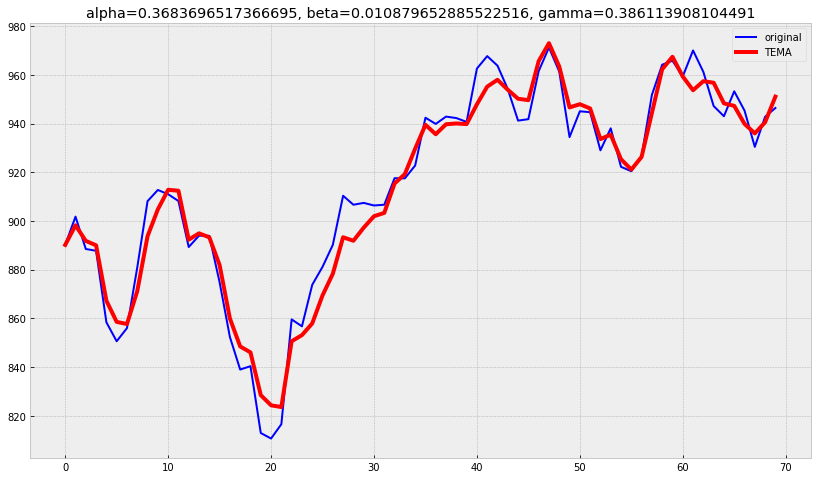

In [13]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

In [14]:
series = boxcox(series, 0) #Уберем изменение дисперсии при помощи преобразования Бокса-Кокса
series = series[1:] - series[:-1] #Дифференцируем.

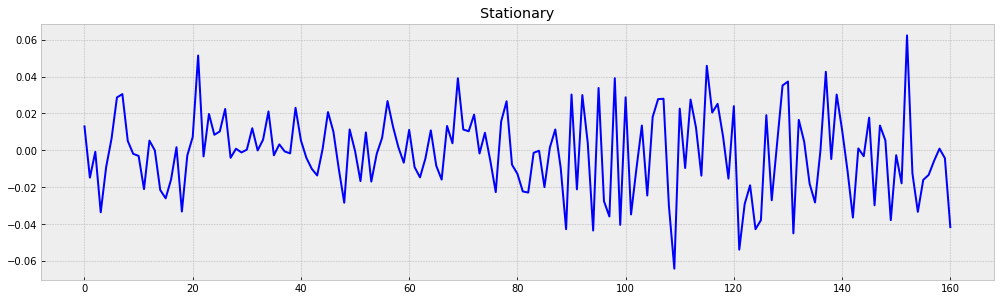

In [15]:
tsplot(series)

In [16]:
train, test, val = series[:60], series[60:70], series[70:]

In [17]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

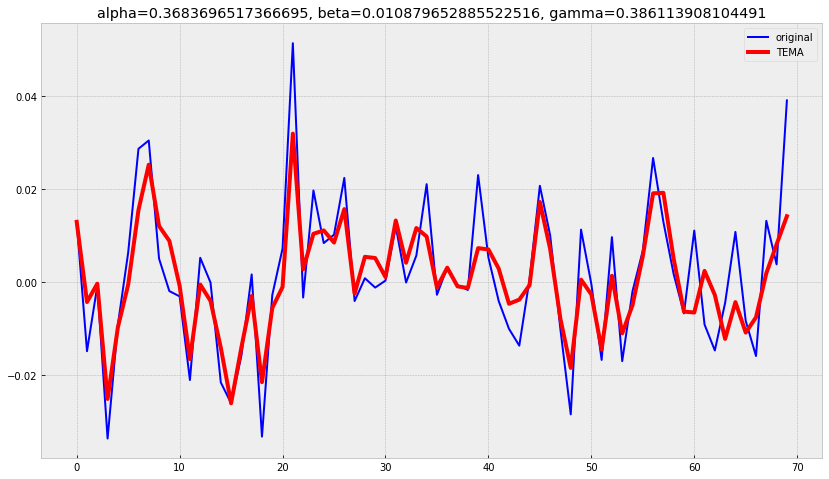

In [18]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series[:70], n_preds=len(test))

In [19]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.00013349698733867223
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.25946474e-07,  1.21837870e-04, -1.15455470e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 10
     njev: 11
   status: 0
  success: True
        x: array([0.02114327, 0.        , 0.00429633])


**Вывод:** Был взят метод Хольта-Винтерса, что бы посмотреть как работает с сезонностью и без, на стационарном варианте ошибка минимальна по сравнению с оригиналом.